#Лабораторна робота №1. Гібридні Нейронні Мережі MLP / RBN

**Виконала** студентка групи КІ-41мп Додонова Марія.

**Мета:** Дослідження впливу функції активації на точність нейронних мереж на основі багатощарових персептронів.

##Порядок виконання

1. В ході виконання роботи буде створено три моделі: багатошаровий персептрон, радиальна базисна мережа та гібридна мережа.
2. Спочатку навчаються базові варіанти персептрону та базисної мережі. Рекомендується використовувати щонайменше **дві різних функції активації** та **два набори даних**: аналітичний (IRIS / TITANIC SURVIVORS) та протовисокомірний (MNIST / FASHION MNIST) для дослідження того як тип даних впливає на ефективність функцій активації.
При навчанні слід зберегти метрики навчання та валідації, такі як loss, average accuracy, per-class precision & recall.
3. Після навчання базових варіантів формується гібридна нейронна мережа: виконується навчання багатошарового персептрону, після чого відкидаєтсья класифікуюча голова, і виходи із прихованого шару направляються до входів радіальної базисної мережі.
При навчанні можна використовувати одну комбінацію функцій активацій, але також слід провести тестування на двох різних типів наборів даних.
При навчанні слід зберегти метрики навчання та валідації, такі як loss, average accuracy, per-class precision & recall.
4. Провести порівняння результатів базових і гібридної нейрнної мережі. Провести аналіз отриманих результатів.
5. Оформити отримані результати у протоколі.


##Виконання роботи

Завантажимо два набори даних: аналітичний (IRIS) та протовисокомірний (MNIST) для дослідження того як тип даних впливає на ефективність функцій активації.

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.datasets import load_iris
import numpy as np

SEED = 42
np.random.seed(SEED)
random_state = check_random_state(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Normalize features using StandardScaler
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)

# Convert labels to integer format
y_iris = np.array([int(label) for label in y_iris])

# Split IRIS into training (80%) and validation (20%) sets
X_train_iris, X_val_iris, y_train_iris, y_val_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42
)

# Convert data to PyTorch tensors
X_train_iris = torch.tensor(X_train_iris, dtype=torch.float32)
y_train_iris = torch.tensor(y_train_iris, dtype=torch.long)
X_val_iris = torch.tensor(X_val_iris, dtype=torch.float32)
y_val_iris = torch.tensor(y_val_iris, dtype=torch.long)

# Create DataLoaders for IRIS dataset
iris_train_loader = DataLoader(TensorDataset(X_train_iris, y_train_iris),
                               batch_size=16, shuffle=True)
iris_val_loader = DataLoader(TensorDataset(X_val_iris, y_val_iris),
                             batch_size=16, shuffle=True)


# Define transformations for MNIST (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
mnist_train = MNIST(root="./data", train=True,
                    transform=transform, download=True)
mnist_test = MNIST(root="./data", train=False,
                   transform=transform, download=True)

# Split MNIST into training (90%) and validation (10%) sets
mnist_train_size = int(0.9 * len(mnist_train))
mnist_val_size = len(mnist_train) - mnist_train_size
mnist_train, mnist_val = random_split(
    mnist_train, [mnist_train_size, mnist_val_size]
)

# Create DataLoaders for MNIST dataset
mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

Створимо багатошаровий персептрон та радиальну базисну мережу. Використовуватимемо по дві різних функції активації (ReLU та Tanh для персептрона і Gaussian та Multiquadratic для радиальної базисної мережі).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size_1, hidden_size_2,
               output_size, hidden_activation="relu"):
    super(MLP, self).__init__()

    # Define layers
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, hidden_size_1)
    self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.fc3 = nn.Linear(hidden_size_2, output_size)

    # Get activation functions
    if hidden_activation == "relu":
      self.hidden_activation = nn.ReLU()
    elif hidden_activation == "tanh":
      self.hidden_activation = nn.Tanh()
    else:
      raise ValueError(f"Unknown hidden function: {hidden_activation}")

    self.output_activation = nn.Identity()

  def forward(self, x, return_features=False):
    x = self.flatten(x)

    x = self.fc1(x)
    x = self.hidden_activation(x)

    x = self.fc2(x)
    x = self.hidden_activation(x)

    if return_features:
      return x

    x = self.fc3(x)
    x = self.output_activation(x)

    return x


class RBFNetwork(nn.Module):
  def __init__(self, input_size, rbf_size, output_size, X_train,
               basis_function="gaussian"):
    super(RBFNetwork, self).__init__()
    self.flatten = nn.Flatten()

    kmeans = KMeans(n_clusters=rbf_size, random_state=0).fit(X_train)
    self.centers = torch.tensor(kmeans.cluster_centers_,
                                dtype=torch.float32, requires_grad=False)

    d_max = np.max(np.linalg.norm(
        kmeans.cluster_centers_[:, None] - kmeans.cluster_centers_,
        axis=2))

    self.sigma = torch.tensor(d_max / np.sqrt(2 * rbf_size),
                              dtype=torch.float32, requires_grad=False)

    self.linear = nn.Linear(rbf_size, output_size, bias=True)

    if basis_function == "gaussian":
      self.basis_function = self._gaussian
    elif basis_function == "multiquadric":
      self.basis_function = self._multiquadric
    else:
      raise ValueError(f"Unknown basis function: {basis_function}")

  def _gaussian(self, x):
    return torch.exp(-torch.sum(
        (x - self.centers) ** 2, dim=2) / (2 * self.sigma ** 2))

  def _multiquadric(self, x):
    return torch.sqrt(torch.sum(
        (x - self.centers) ** 2, dim=2) + self.sigma ** 2)

  def forward(self, x):
    x = self.flatten(x)
    x = x.unsqueeze(1)  # (batch_size, 1, input_dim)

    rbf_activations = self.basis_function(x)  # (batch_size, hidden_dim)

    output = self.linear(rbf_activations)
    return output

In [ ]:
iris_input_size = 4
iris_hidden_size_1 = 16
iris_hidden_size_2 = 12
iris_output_size = 3

iris_mlp_relu = MLP(iris_input_size, iris_hidden_size_1,
                    iris_hidden_size_2, iris_output_size)
iris_mlp_tanh = MLP(iris_input_size, iris_hidden_size_1,
                    iris_hidden_size_2, iris_output_size,
                    hidden_activation="tanh")

mnist_input_size = 28 * 28
mnist_hidden_size_1 = 128
mnist_hidden_size_2 = 64
mnist_output_size = 10

mnist_mlp_relu = MLP(mnist_input_size, mnist_hidden_size_1,
                     mnist_hidden_size_2, mnist_output_size)
mnist_mlp_tanh = MLP(mnist_input_size, mnist_hidden_size_1,
                     mnist_hidden_size_2, mnist_output_size,
                     hidden_activation="tanh")

print("MLP model with ReLU activations for IRIS dataset:")
print(iris_mlp_relu)
print()
print("MLP model with Tanh activations for IRIS dataset:")
print(iris_mlp_tanh)
print()
print("MLP model with ReLU activations for MNIST dataset:")
print(mnist_mlp_relu)
print()
print("MLP model with Tanh activations for MNIST dataset:")
print(mnist_mlp_tanh)

MLP model with ReLU activations for IRIS dataset:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=3, bias=True)
  (hidden_activation): ReLU()
  (output_activation): Identity()
)

MLP model with Tanh activations for IRIS dataset:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=3, bias=True)
  (hidden_activation): Tanh()
  (output_activation): Identity()
)

MLP model with ReLU activations for MNIST dataset:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (hidden_activation): 

In [ ]:
X_train_mnist = []
for images, _ in mnist_train_loader:
  images = images.view(images.size(0), -1)
  X_train_mnist.append(images)

X_train_mnist = torch.vstack(X_train_mnist).numpy()

iris_rbf_size = 10
mnist_rbf_size = 50

iris_rbfn_gaussian = RBFNetwork(iris_input_size, iris_rbf_size,
                                iris_output_size, X_train_iris)
iris_rbfn_multiquadric = RBFNetwork(iris_input_size, iris_rbf_size,
                                    iris_output_size, X_train_iris,
                                    basis_function="multiquadric")

mnist_rbfn_gaussian = RBFNetwork(mnist_input_size, mnist_rbf_size,
                                 mnist_output_size, X_train_mnist)
mnist_rbfn_multiquadric = RBFNetwork(mnist_input_size,
                                     mnist_rbf_size,
                                     mnist_output_size, X_train_mnist,
                                     basis_function="multiquadric")


print("RBF model with Gaussian basis functions for IRIS dataset:")
print(iris_rbfn_gaussian)
print()
print("RBF model with Multiquadric basis functions for IRIS dataset:")
print(iris_rbfn_multiquadric)
print()
print("RBF model with Gaussian basis functions for MNIST dataset:")
print(mnist_rbfn_gaussian)
print()
print("RBF model with Multiquadric basis functions for MNIST dataset:")
print(mnist_rbfn_multiquadric)

RBF model with Gaussian basis functions for IRIS dataset:
RBFNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10, out_features=3, bias=True)
)

RBF model with Multiquadric basis functions for IRIS dataset:
RBFNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10, out_features=3, bias=True)
)

RBF model with Gaussian basis functions for MNIST dataset:
RBFNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=50, out_features=10, bias=True)
)

RBF model with Multiquadric basis functions for MNIST dataset:
RBFNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=50, out_features=10, bias=True)
)


Під час навчання зберігатимемо метрики навчання та валідації loss, average accuracy, per-class precision & recall.

In [ ]:
from collections import defaultdict

metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

# Models and activations
models = {
    "MLP": ["ReLU", "Tanh"],
    "RBF": ["Gaussian", "Multiquadric"],
    "Hybrid": ["Tanh + Gaussian", "ReLU + Multiquadric"]
}

datasets = ["IRIS", "MNIST"]

# Initialize metrics
for model, activations in models.items():
  if model == "Hybrid":
    for activation, dataset in zip(activations, datasets):
      metrics[model][activation][dataset] = {
          "train_loss": [], "val_loss": [],
          "train_accuracy": [], "val_accuracy": [],
          "train_precision": [], "val_precision": [],
          "train_recall": [], "val_recall": []
      }
    continue

  for activation in activations:
    for dataset in datasets:
      metrics[model][activation][dataset] = {
          "train_loss": [], "val_loss": [],
          "train_accuracy": [], "val_accuracy": [],
          "train_precision": [], "val_precision": [],
          "train_recall": [], "val_recall": []
      }

Навчимо базові варіанти багатошарового персептрону та радиальної базисної мережі.

In [ ]:
from sklearn.metrics import precision_score, recall_score

def train(model, optimizer, criterion, loader):
  model.train()
  running_loss = 0.0
  correct, total = 0, 0
  all_preds, all_labels = [], []

  for features, labels in loader:
    optimizer.zero_grad()
    outputs = model(features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    all_preds.extend(predicted.numpy())
    all_labels.extend(labels.numpy())

  train_loss = running_loss / len(loader)
  accuracy = correct / total
  precision = precision_score(all_labels, all_preds,
                              zero_division=0, average="weighted")
  recall = recall_score(all_labels, all_preds,
                        zero_division=0, average="weighted")

  return train_loss, accuracy, precision, recall


def validate(model, optimizer, criterion, loader):
  model.eval()
  running_loss = 0.0
  correct, total = 0, 0
  all_preds, all_labels = [], []

  with torch.no_grad():
    for features, labels in loader:
      outputs = model(features)
      loss = criterion(outputs, labels)

      running_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      all_preds.extend(predicted.numpy())
      all_labels.extend(labels.numpy())

  val_loss = running_loss / len(loader)
  accuracy = correct / total
  precision = precision_score(all_labels, all_preds,
                              zero_division=0, average="weighted")
  recall = recall_score(all_labels, all_preds,
                        zero_division=0, average="weighted")

  return val_loss, accuracy, precision, recall

In [ ]:
import torch.optim as optim

def train_model(model, metrics, train_loader, val_loader,
                num_epochs=5, lr=0.001):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    train_loss, train_accuracy, train_precision, train_recall = train(
        model, optimizer, criterion, train_loader
    )
    val_loss, val_accuracy, val_precision, val_recall = validate(
        model, optimizer, criterion, val_loader
    )

    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_accuracy)
    metrics["train_precision"].append(train_precision)
    metrics["train_recall"].append(train_recall)

    metrics["val_loss"].append(val_loss)
    metrics["val_accuracy"].append(val_accuracy)
    metrics["val_precision"].append(val_precision)
    metrics["val_recall"].append(val_recall)

    print(
        f"Epoch [{epoch+1:2d}/{num_epochs}]:",
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},",
        f"Train Accuracy: {train_accuracy:.4f},",
        f"Val Accuracy: {val_accuracy:.4f}."
    )

  print("Finished Training!")

In [ ]:
print("Training MLP model with activation ReLU on IRIS Dataset:")
train_model(
    iris_mlp_relu, metrics["MLP"]["ReLU"]["IRIS"],
    iris_train_loader, iris_val_loader, num_epochs=20
)

Training MLP model with activation ReLU on IRIS Dataset:
Epoch [ 1/20]: Train Loss: 1.1156, Val Loss: 1.1258, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 2/20]: Train Loss: 1.1044, Val Loss: 1.1127, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 3/20]: Train Loss: 1.0906, Val Loss: 1.0940, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 4/20]: Train Loss: 1.0718, Val Loss: 1.0738, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 5/20]: Train Loss: 1.0509, Val Loss: 1.0483, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 6/20]: Train Loss: 1.0421, Val Loss: 1.0317, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 7/20]: Train Loss: 1.0148, Val Loss: 1.0056, Train Accuracy: 0.3333, Val Accuracy: 0.3333.
Epoch [ 8/20]: Train Loss: 0.9791, Val Loss: 0.9755, Train Accuracy: 0.3333, Val Accuracy: 0.4667.
Epoch [ 9/20]: Train Loss: 0.9578, Val Loss: 0.9429, Train Accuracy: 0.4417, Val Accuracy: 0.5667.
Epoch [10/20]: Train Loss: 0.9133, Val Loss: 0.9100,

In [ ]:
print("Training MLP model with activation Tanh on IRIS Dataset:")
train_model(
    iris_mlp_tanh, metrics["MLP"]["Tanh"]["IRIS"],
    iris_train_loader, iris_val_loader, num_epochs=20
)

Training MLP model with activation Tanh on IRIS Dataset:
Epoch [ 1/20]: Train Loss: 1.1087, Val Loss: 1.0638, Train Accuracy: 0.2917, Val Accuracy: 0.5333.
Epoch [ 2/20]: Train Loss: 1.0640, Val Loss: 1.0206, Train Accuracy: 0.4917, Val Accuracy: 0.6667.
Epoch [ 3/20]: Train Loss: 1.0179, Val Loss: 0.9784, Train Accuracy: 0.6250, Val Accuracy: 0.7333.
Epoch [ 4/20]: Train Loss: 0.9864, Val Loss: 0.9346, Train Accuracy: 0.6917, Val Accuracy: 0.7667.
Epoch [ 5/20]: Train Loss: 0.9449, Val Loss: 0.8939, Train Accuracy: 0.7417, Val Accuracy: 0.7667.
Epoch [ 6/20]: Train Loss: 0.9003, Val Loss: 0.8489, Train Accuracy: 0.7583, Val Accuracy: 0.8000.
Epoch [ 7/20]: Train Loss: 0.8635, Val Loss: 0.8096, Train Accuracy: 0.8000, Val Accuracy: 0.8333.
Epoch [ 8/20]: Train Loss: 0.8378, Val Loss: 0.7637, Train Accuracy: 0.8000, Val Accuracy: 0.8333.
Epoch [ 9/20]: Train Loss: 0.7744, Val Loss: 0.7180, Train Accuracy: 0.8083, Val Accuracy: 0.8333.
Epoch [10/20]: Train Loss: 0.7455, Val Loss: 0.6755,

In [ ]:
print("Training MLP model with activation ReLU on MNIST Dataset:")
train_model(
    mnist_mlp_relu, metrics["MLP"]["ReLU"]["MNIST"],
    mnist_train_loader, mnist_val_loader
)

Training MLP model with activation ReLU on MNIST Dataset:
Epoch [ 1/5]: Train Loss: 0.2951, Val Loss: 0.1602, Train Accuracy: 0.9138, Val Accuracy: 0.9517.
Epoch [ 2/5]: Train Loss: 0.1235, Val Loss: 0.1254, Train Accuracy: 0.9618, Val Accuracy: 0.9633.
Epoch [ 3/5]: Train Loss: 0.0846, Val Loss: 0.1180, Train Accuracy: 0.9739, Val Accuracy: 0.9637.
Epoch [ 4/5]: Train Loss: 0.0643, Val Loss: 0.1028, Train Accuracy: 0.9795, Val Accuracy: 0.9695.
Epoch [ 5/5]: Train Loss: 0.0503, Val Loss: 0.1171, Train Accuracy: 0.9836, Val Accuracy: 0.9665.
Finished Training!


In [ ]:
print("Training MLP model with activation Tanh on MNIST Dataset:")
train_model(
    mnist_mlp_tanh, metrics["MLP"]["Tanh"]["MNIST"],
    mnist_train_loader, mnist_val_loader
)

Training MLP model with activation Tanh on MNIST Dataset:
Epoch [ 1/5]: Train Loss: 0.2903, Val Loss: 0.1476, Train Accuracy: 0.9196, Val Accuracy: 0.9545.
Epoch [ 2/5]: Train Loss: 0.1149, Val Loss: 0.1308, Train Accuracy: 0.9656, Val Accuracy: 0.9598.
Epoch [ 3/5]: Train Loss: 0.0813, Val Loss: 0.1101, Train Accuracy: 0.9755, Val Accuracy: 0.9677.
Epoch [ 4/5]: Train Loss: 0.0652, Val Loss: 0.1101, Train Accuracy: 0.9796, Val Accuracy: 0.9682.
Epoch [ 5/5]: Train Loss: 0.0540, Val Loss: 0.1073, Train Accuracy: 0.9827, Val Accuracy: 0.9683.
Finished Training!


In [ ]:
print("Training RBF model with Gaussian basis functions on IRIS Dataset:")
train_model(
    iris_rbfn_gaussian, metrics["RBF"]["Gaussian"]["IRIS"],
    iris_train_loader, iris_val_loader, num_epochs=20
)

Training RBF model with Gaussian basis functions on IRIS Dataset:
Epoch [ 1/20]: Train Loss: 1.1249, Val Loss: 1.0975, Train Accuracy: 0.2250, Val Accuracy: 0.3000.
Epoch [ 2/20]: Train Loss: 1.1061, Val Loss: 1.0820, Train Accuracy: 0.2667, Val Accuracy: 0.3667.
Epoch [ 3/20]: Train Loss: 1.0867, Val Loss: 1.0687, Train Accuracy: 0.3167, Val Accuracy: 0.3667.
Epoch [ 4/20]: Train Loss: 1.0770, Val Loss: 1.0523, Train Accuracy: 0.3250, Val Accuracy: 0.3667.
Epoch [ 5/20]: Train Loss: 1.0628, Val Loss: 1.0374, Train Accuracy: 0.3583, Val Accuracy: 0.4000.
Epoch [ 6/20]: Train Loss: 1.0468, Val Loss: 1.0246, Train Accuracy: 0.3833, Val Accuracy: 0.4000.
Epoch [ 7/20]: Train Loss: 1.0342, Val Loss: 1.0112, Train Accuracy: 0.4000, Val Accuracy: 0.4333.
Epoch [ 8/20]: Train Loss: 1.0194, Val Loss: 0.9962, Train Accuracy: 0.4000, Val Accuracy: 0.4333.
Epoch [ 9/20]: Train Loss: 1.0055, Val Loss: 0.9821, Train Accuracy: 0.4333, Val Accuracy: 0.4667.
Epoch [10/20]: Train Loss: 0.9943, Val Loss

In [ ]:
print("Training RBF model with Multiquadric basis functions on IRIS Dataset:")
train_model(
    iris_rbfn_multiquadric, metrics["RBF"]["Multiquadric"]["IRIS"],
    iris_train_loader, iris_val_loader, num_epochs=20
)

Training RBF model with Multiquadric basis functions on IRIS Dataset:
Epoch [ 1/20]: Train Loss: 2.1390, Val Loss: 2.2678, Train Accuracy: 0.3417, Val Accuracy: 0.3000.
Epoch [ 2/20]: Train Loss: 1.9488, Val Loss: 2.0666, Train Accuracy: 0.3417, Val Accuracy: 0.3000.
Epoch [ 3/20]: Train Loss: 1.7986, Val Loss: 1.9465, Train Accuracy: 0.3417, Val Accuracy: 0.3000.
Epoch [ 4/20]: Train Loss: 1.7138, Val Loss: 1.8166, Train Accuracy: 0.3417, Val Accuracy: 0.3000.
Epoch [ 5/20]: Train Loss: 1.6247, Val Loss: 1.7438, Train Accuracy: 0.3500, Val Accuracy: 0.3000.
Epoch [ 6/20]: Train Loss: 1.5395, Val Loss: 1.6413, Train Accuracy: 0.3500, Val Accuracy: 0.3000.
Epoch [ 7/20]: Train Loss: 1.4819, Val Loss: 1.5713, Train Accuracy: 0.3417, Val Accuracy: 0.3000.
Epoch [ 8/20]: Train Loss: 1.4100, Val Loss: 1.4948, Train Accuracy: 0.3417, Val Accuracy: 0.3000.
Epoch [ 9/20]: Train Loss: 1.3655, Val Loss: 1.4230, Train Accuracy: 0.3333, Val Accuracy: 0.2667.
Epoch [10/20]: Train Loss: 1.3022, Val 

In [ ]:
print("Training RBF model with Gaussian basis functions on MNIST Dataset:")
train_model(
    mnist_rbfn_gaussian, metrics["RBF"]["Gaussian"]["MNIST"],
    mnist_train_loader, mnist_val_loader
)

Training RBF model with Gaussian basis functions on MNIST Dataset:
Epoch [ 1/5]: Train Loss: 2.3018, Val Loss: 2.2997, Train Accuracy: 0.1089, Val Accuracy: 0.1110.
Epoch [ 2/5]: Train Loss: 2.2997, Val Loss: 2.2989, Train Accuracy: 0.1125, Val Accuracy: 0.1110.
Epoch [ 3/5]: Train Loss: 2.2987, Val Loss: 2.2980, Train Accuracy: 0.1125, Val Accuracy: 0.1110.
Epoch [ 4/5]: Train Loss: 2.2977, Val Loss: 2.2970, Train Accuracy: 0.1125, Val Accuracy: 0.1110.
Epoch [ 5/5]: Train Loss: 2.2967, Val Loss: 2.2960, Train Accuracy: 0.1125, Val Accuracy: 0.1110.
Finished Training!


In [ ]:
print("Training RBF model with Multiquadric basis functions on MNIST Dataset:")
train_model(
    mnist_rbfn_multiquadric, metrics["RBF"]["Multiquadric"]["MNIST"],
    mnist_train_loader, mnist_val_loader
)

Training RBF model with Multiquadric basis functions on MNIST Dataset:
Epoch [ 1/5]: Train Loss: 2.0182, Val Loss: 0.8970, Train Accuracy: 0.4664, Val Accuracy: 0.6900.
Epoch [ 2/5]: Train Loss: 0.7572, Val Loss: 0.6783, Train Accuracy: 0.7464, Val Accuracy: 0.7758.
Epoch [ 3/5]: Train Loss: 0.6381, Val Loss: 0.6158, Train Accuracy: 0.7883, Val Accuracy: 0.7985.
Epoch [ 4/5]: Train Loss: 0.5783, Val Loss: 0.5555, Train Accuracy: 0.8134, Val Accuracy: 0.8197.
Epoch [ 5/5]: Train Loss: 0.5475, Val Loss: 0.5992, Train Accuracy: 0.8224, Val Accuracy: 0.7937.
Finished Training!


Сформуємо гібридну нейронну мережу: після навчання багатошарового персептрону відкинемо класифікуючу голову, а виходи із прихованого шару направимо до входів радіальної базисної мережі.

In [ ]:
class HybridNetwork(nn.Module):
  def __init__(self, mlp_model, rbf_size, output_size,
               X_train, basis_function="gaussian"):
    super(HybridNetwork, self).__init__()

    self.mlp = mlp_model

    with torch.no_grad():
      X_train_transformed = self.mlp(
          torch.tensor(X_train).float(),
          return_features=True)

    self.rbf = RBFNetwork(self.mlp.fc2.out_features, rbf_size,
                          output_size, X_train_transformed,
                          basis_function=basis_function)

  def forward(self, x):
    features = self.mlp(x, return_features=True)
    output = self.rbf(features)
    return output

In [ ]:
iris_hn = HybridNetwork(iris_mlp_relu, iris_rbf_size,
                        iris_output_size, X_train_iris)

mnist_hn = HybridNetwork(mnist_mlp_tanh, mnist_rbf_size,
                         mnist_output_size, X_train_mnist,
                         basis_function="multiquadric")


print("Hybrid Network with ReLU activations and",
      "Gaussian basis functions for IRIS dataset:")
print(iris_hn)
print()
print("Hybrid Network with Tanh activations and",
      "Multiquadric basis functions for MNIST dataset:")
print(mnist_hn)

<ipython-input-16-23f205c03424>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train).float(),


Hybrid Network with ReLU activations and Gaussian basis functions for IRIS dataset:
HybridNetwork(
  (mlp): MLP(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=4, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=12, bias=True)
    (fc3): Linear(in_features=12, out_features=3, bias=True)
    (hidden_activation): ReLU()
    (output_activation): Identity()
  )
  (rbf): RBFNetwork(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=10, out_features=3, bias=True)
  )
)

Hybrid Network with Tanh activations and Multiquadric basis functions for MNIST dataset:
HybridNetwork(
  (mlp): MLP(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
    (hidden_activation): Tanh()
    (output_activation): Identity()
  )
  (rbf): RBFNetw

Використаємо одну комбінацію функцій активацій при навчанні, і проведемо тестування на різних типах наборів даних. Збережемо метрики навчання та валідації loss, average accuracy, per-class precision & recall

In [ ]:
print("Training Hybrid Network with Tanh activations and",
      "Gaussian basis functions on IRIS Dataset:")
train_model(
    iris_hn, metrics["Hybrid"]["Tanh + Gaussian"]["IRIS"],
    iris_train_loader, iris_val_loader, num_epochs=20
)

Training Hybrid Network with Tanh activations and Gaussian basis functions on IRIS Dataset:
Epoch [ 1/20]: Train Loss: 1.2882, Val Loss: 1.2414, Train Accuracy: 0.0250, Val Accuracy: 0.0667.
Epoch [ 2/20]: Train Loss: 1.2502, Val Loss: 1.2144, Train Accuracy: 0.0583, Val Accuracy: 0.0667.
Epoch [ 3/20]: Train Loss: 1.2169, Val Loss: 1.1810, Train Accuracy: 0.0917, Val Accuracy: 0.2000.
Epoch [ 4/20]: Train Loss: 1.1919, Val Loss: 1.1553, Train Accuracy: 0.1500, Val Accuracy: 0.3333.
Epoch [ 5/20]: Train Loss: 1.1676, Val Loss: 1.1298, Train Accuracy: 0.2167, Val Accuracy: 0.3333.
Epoch [ 6/20]: Train Loss: 1.1378, Val Loss: 1.1061, Train Accuracy: 0.2917, Val Accuracy: 0.3667.
Epoch [ 7/20]: Train Loss: 1.1193, Val Loss: 1.0826, Train Accuracy: 0.3167, Val Accuracy: 0.3667.
Epoch [ 8/20]: Train Loss: 1.0932, Val Loss: 1.0646, Train Accuracy: 0.3250, Val Accuracy: 0.3667.
Epoch [ 9/20]: Train Loss: 1.0702, Val Loss: 1.0474, Train Accuracy: 0.3417, Val Accuracy: 0.4000.
Epoch [10/20]: Tr

In [ ]:
print("Training Hybrid Network with ReLU activations and",
      "Multiquadric basis functions on MNIST Dataset:")
train_model(
    mnist_hn, metrics["Hybrid"]["ReLU + Multiquadric"]["MNIST"],
    mnist_train_loader, mnist_val_loader
)

Training Hybrid Network with ReLU activations and Multiquadric basis functions on MNIST Dataset:
Epoch [ 1/5]: Train Loss: 0.6023, Val Loss: 0.2002, Train Accuracy: 0.8771, Val Accuracy: 0.9505.
Epoch [ 2/5]: Train Loss: 0.1323, Val Loss: 0.1649, Train Accuracy: 0.9677, Val Accuracy: 0.9552.
Epoch [ 3/5]: Train Loss: 0.0928, Val Loss: 0.1387, Train Accuracy: 0.9750, Val Accuracy: 0.9620.
Epoch [ 4/5]: Train Loss: 0.0752, Val Loss: 0.1194, Train Accuracy: 0.9784, Val Accuracy: 0.9668.
Epoch [ 5/5]: Train Loss: 0.0646, Val Loss: 0.1219, Train Accuracy: 0.9814, Val Accuracy: 0.9652.
Finished Training!


Порівняємо та проаналізуємо результати базових і гібридної нейрнної мережі.


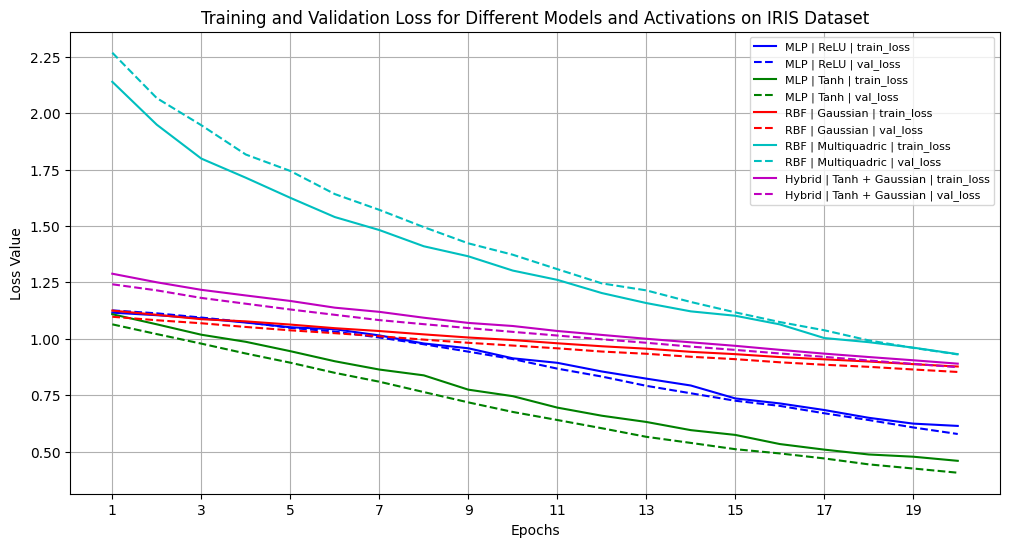

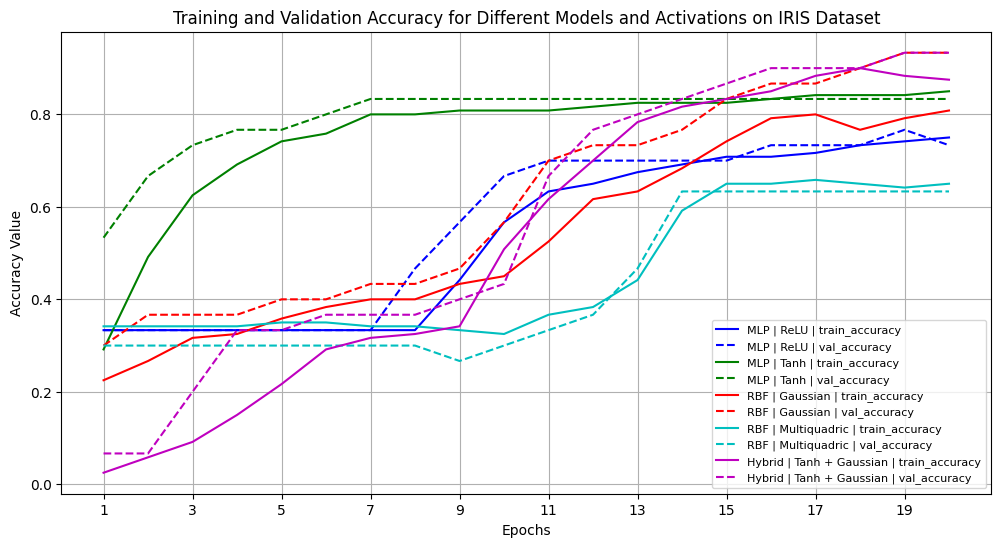

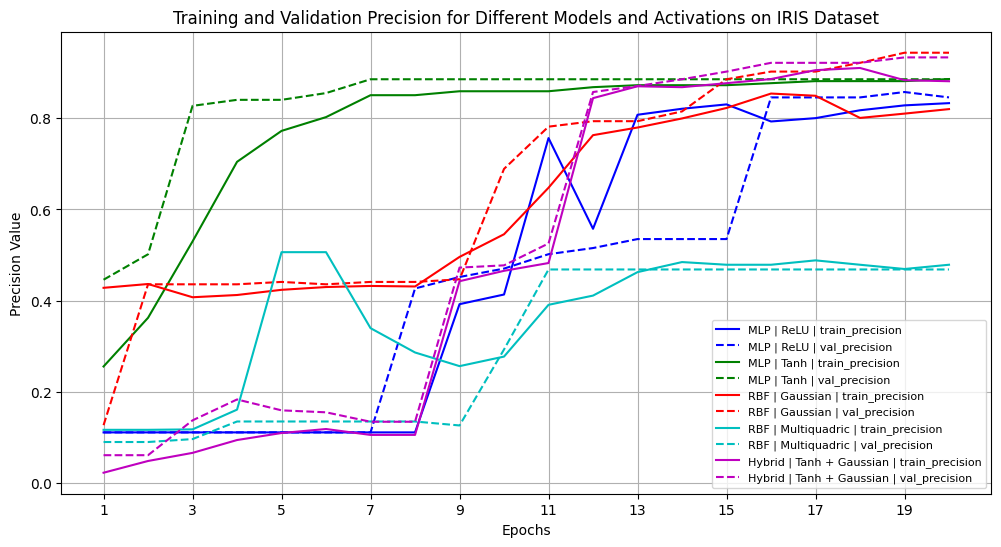

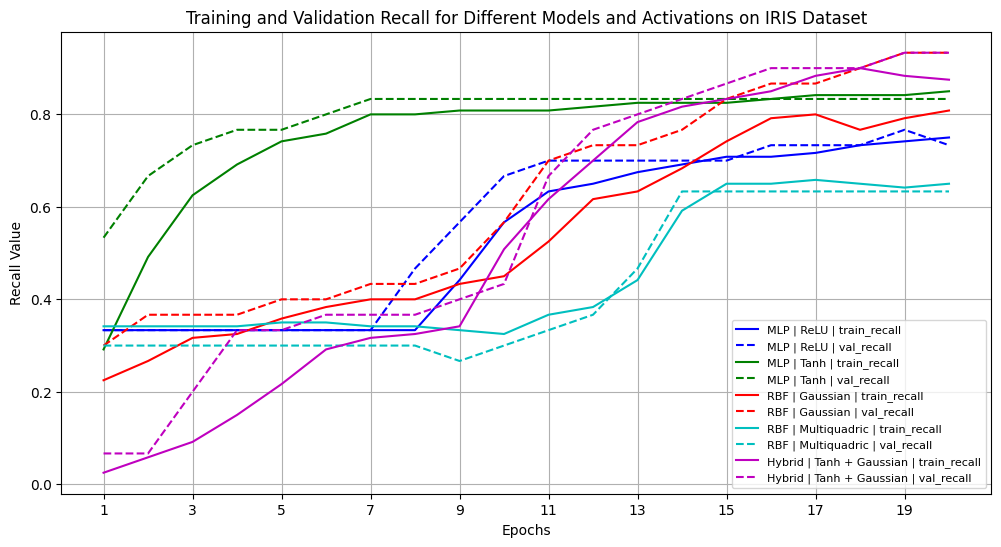

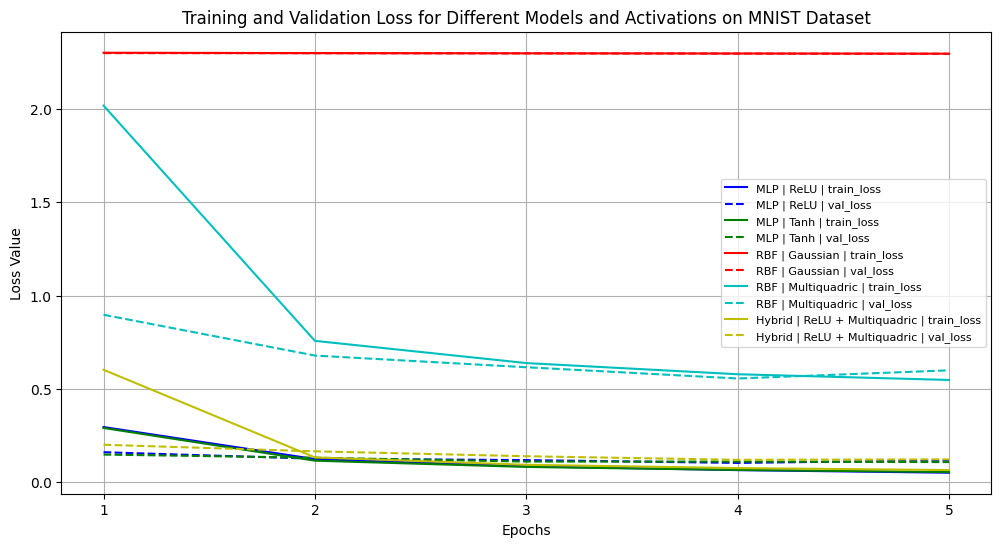

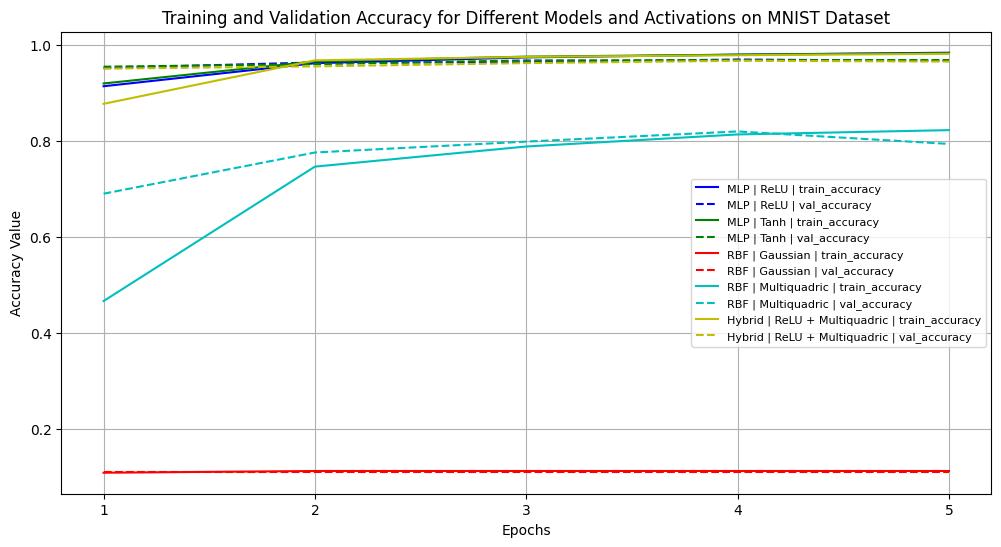

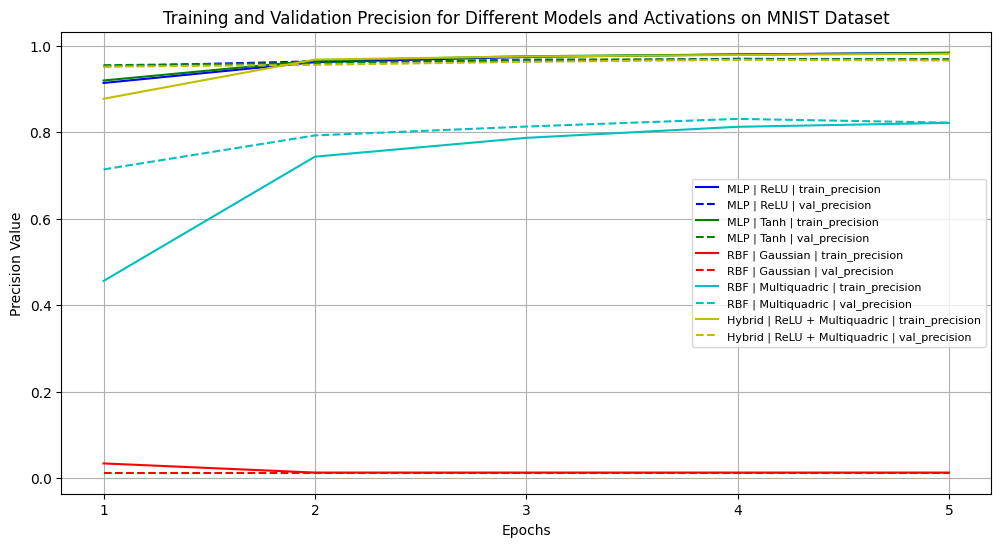

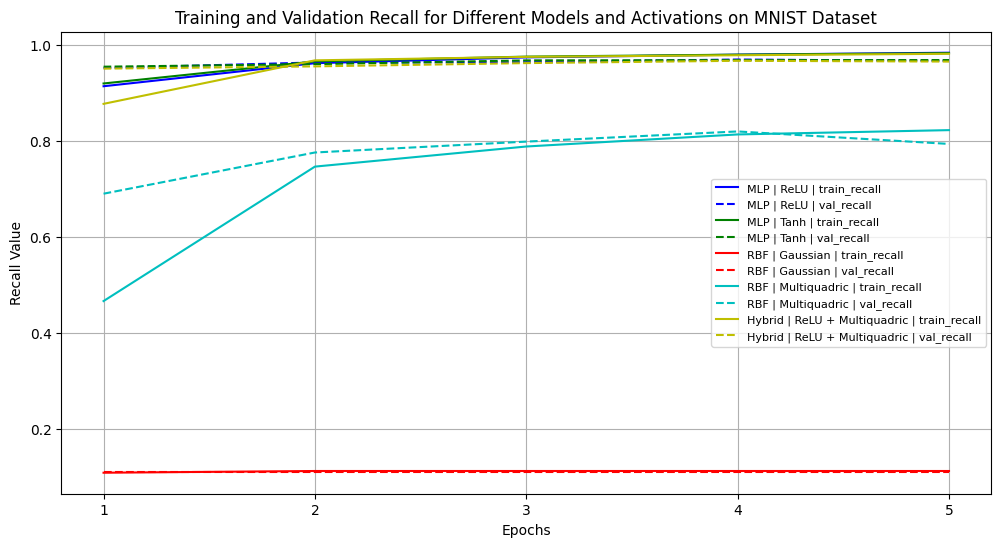

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(metrics, dataset, metric_name):
  plt.figure(figsize=(12, 6))
  colors = ["b", "g", "r", "c", "m", "y"]

  i = 0
  for model, activations in metrics.items():
    for activation, datasets in activations.items():
      metric_data = datasets[dataset]
      for metric, values in metric_data.items():
        if metric_name in metric:
          num_epochs = len(values)
          label = f"{model} | {activation} | {metric}"
          color = colors[i % len(colors)]
          linestyle = "--" if "val" in metric else "-"
          plt.plot(values, linestyle=linestyle,
                   color=color, label=label)
      i += 1

  plt.xlabel("Epochs")
  plt.ylabel(f"{metric_name.capitalize()} Value")
  plt.title(f"Training and Validation {metric_name.capitalize()} "\
            f"for Different Models and Activations on {dataset} Dataset")

  tick_positions = np.arange(0, num_epochs, step=max(1, num_epochs // 10))
  tick_labels = [str(i+1) for i in tick_positions]
  plt.xticks(tick_positions, tick_labels)

  plt.legend(loc="best", fontsize=8)
  plt.grid(True)
  plt.show()


for dataset in ["IRIS", "MNIST"]:
  for metric_name in ["loss", "accuracy", "precision",  "recall"]:
    plot_training_curves(metrics, dataset, metric_name)

У навчанні багатошарового персептрона з активаціями ReLU та Tanh на наборах даних IRIS і MNIST спостерігаються значні відмінності. Для IRIS модель з ReLU мала низьку початкову точність (33.33%) і покращувалась лише після восьмої епохи, що може бути пов’язано з відмиранням нейронів. Модель з Tanh навчалась швидше та досягла вищої точності (83.33% проти 73.33%).  
На наборі MNIST персептрон швидко збільшив свою точність: після першої епохи – 91.38% (тренувальна) та 95.17% (валідаційна вибірка), остаточні значення – 98.36% і 96.65%. Активація ReLU виявилася ефективною для великих обсягів даних, забезпечуючи швидку збіжність. Активація Tanh показує трохи гіршу узагальнювальну здатність через проблему насичення градієнтів.

RBF-мережа з гаусовими функціями на наборі IRIS поступово покращувала точність, досягнувши 80.83% (тренувальна) і 93.33% (валідаційна вибірки), що свідчить про ефективне навчання. Мультиквадратичні функції показали гірші результати – 65.0% і 63.33%, що може вказувати на менш ефективну репрезентацію простору ознак.  
На MNIST модель з гаусовими функціями не навчилася взагалі – точність залишалась на рівні випадкового вгадування (~11.25%), що свідчить про невідповідність цієї функції задачі. Мережа з мультиквадратичними функціями адаптувалась значно краще: точність на першій епосі – 46.64% (тренувальна) і 69.0% (валідаційна вибірка), остаточні значення – 82.24% і 79.37%. Однак після 4-ї епохи спостерігалось перенавчання, що вказує на необхідність регуляризації.  
Можна зробити висновок, що гаусові функції ефективні для невеликих датасетів, як IRIS, тоді як мультиквадратичні функції краще працюють на складніших наборах, як MNIST.

Гібридна нейромережа, що використовує активацію Tanh у багатошаровому персептроні та Гаусову базисну функцію у RBF-мережі, демонструє поступове покращення продуктивності. Початкове тренувальне значення точності становило лише 2.5%, а валідаційне — 6.67%, що свідчить про складність задачі для моделі на ранніх етапах. Однак, після 10 епох точність різко зростає, а на фінальному етапі точність навчання склала 87.50%, а валідаційна — 93.33%, що свідчить про гарну узагальнюючу здатність моделі. Втрати знижувалися стабільно, що говорить про ефективне навчання.  
У випадку набору MNIST була використана активація ReLU у персептроні та мультиквадратична базисна функція у RBF. Модель демонструє високу ефективність вже з першої епохи: тренувальна точність 87.71%, валідаційна — 95.05%. Це свідчить про хорошу здатність мережі до узагальнення. Після 5 епох тренувальна точність зросла до 98.14%, а валідаційна склала 96.52%. Втрати стабільно знижувалися до 0.0646 на тренувальній вибірці та 0.1219 на валідаційній, що свідчить про високу якість навчання.

Загалом, гібридні нейромережі показали кращі результати, ніж окремо багатошарові персептрони та RBF-мережі. На задачах класифікації у малих датасетах як IRIS, використання Tanh + Gaussian дозволило значно покращити точність. На більш складних задачах (MNIST) комбінація ReLU + Multiquadric показала чудову ефективність. Таким чином, гібридний підхід є перспективним для задач, де потрібно поєднати переваги багатошарового персептрона та RBF-мережі для досягнення оптимальної продуктивності.

##Висновок

У ході лабораторної роботи було реалізовано та протестовано три типи нейронних мереж: багатошаровий персептрон, радіальну базисну мережу та гібридну мережу, що поєднує характеристики двох попередніх моделей. Експерименти проводилися на наборах даних IRIS та MNIST. Також було досліджено вплив різних функцій активації та радіальних базисних функцій.  
Аналіз навчання та оцінка якості моделей показали, що багатошаровий персептрон досяг високої точності на обох наборах даних. RBF-мережа показала також хороші результати, проте її продуктивність значною мірою залежала від вибору базисних функцій та набору даних. Гібридна мережа продемонструвала покращену здатність до узагальнення, особливо при комбінації активації Tanh для персептрона та гаусових базисних функцій для RBF-мережі на даних IRIS, а також активації ReLU та мультиквадратичних базисних функцій на MNIST.  
За підсумками експериментів найкращі результати на MNIST продемонструвала гібридна мережа з ReLU та мультиквадратичними базисними функціями, досягнувши найвищої точності на валідаційних даних (96,68%). На IRIS найефективнішою моделлю став багатошаровий персептрон з функцією активації ReLU. Таким чином, використання гібридного підходу може бути корисним у задачах, що потребують гнучкого поєднання лінійних та нелінійних особливостей у даних.